# Visualization

This notebook walks through how to visualize the graphs you create. For this example we will use a prebuilt graph, but this works with ANY graphs.

## Set up the chat model and tools

Here we will define the chat model and tools that we want to use.
Importantly, this model MUST support OpenAI function calling.

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import chat_agent_executor

In [2]:
# Optional to not need .env
# import os
# os.environ['TAVILY_API_KEY'] = 'foo'
# os.environ['OPENAI_API_KEY'] = 'foo'

tools = [TavilySearchResults(max_results=1)]
model = ChatOpenAI()

## Create executor

We can now use the high level interface to create the executor

In [3]:
app = chat_agent_executor.create_tool_calling_executor(model, tools)

## Ascii

We can easily visualize this graph in ascii

In [4]:
app.get_graph().print_ascii()

        +-----------+           
        | __start__ |           
        +-----------+           
               *                
               *                
               *                
          +-------+             
          | agent |             
          +-------+             
          *        ..           
        **           ..         
       *               .        
+--------+         +---------+  
| action |         | __end__ |  
+--------+         +---------+  


## Mermaid

We can also convert a graph class into Mermaid syntax.

In [5]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	agent([agent]):::otherclass;
	action([action]):::otherclass;
	__start__ --> agent;
	action --> agent;
	agent -. continue .-> action;
	agent -. end .-> __end__;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



## PNG

If prefered, we could render the Graph into a  `.png`. Here we could use three options:

- Using graphviz (which requires `pip install graphviz`)
- Using Mermaid + Pyppeteer (requires `pip install pyppeteer`)
- Using Mermaid.ink API (does not require additional packages)

In [6]:
from IPython.display import display, HTML
import base64

def display_image(image_bytes: bytes, width=300):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))

### Using Graphviz

In [7]:
#%%capture --no-stderr
%pip install install pygraphviz

  Using cached pygraphviz-1.12-cp311-cp311-macosx_13_0_arm64.whl
Note: you may need to restart the kernel to use updated packages.



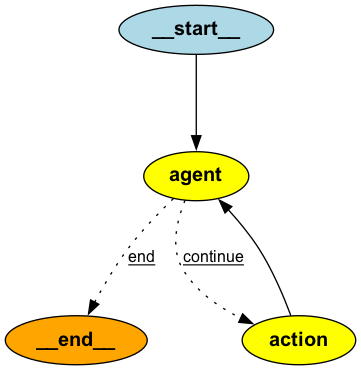

In [8]:
display_image(app.get_graph().draw_png())

### Using Mermaid + Pyppeteer

In [9]:
# %%capture --no-stderr
%pip install install pyppeteer
# %%capture --no-stderr
%pip install install nest_asyncio

  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.1 MB/s eta 0:00:00
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.1
    Uninstalling urllib3-2.2.1:
      Successfully uninstalled urllib3-2.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
types-requests 2.31.0.20240311 requires urllib3>=2, but you have urllib3 1.26.18 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use up

[INFO] Starting Chromium download.
100%|██████████| 141M/141M [00:09<00:00, 14.2Mb/s] 
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/wfh/Library/Application Support/pyppeteer/local-chromium/1181205



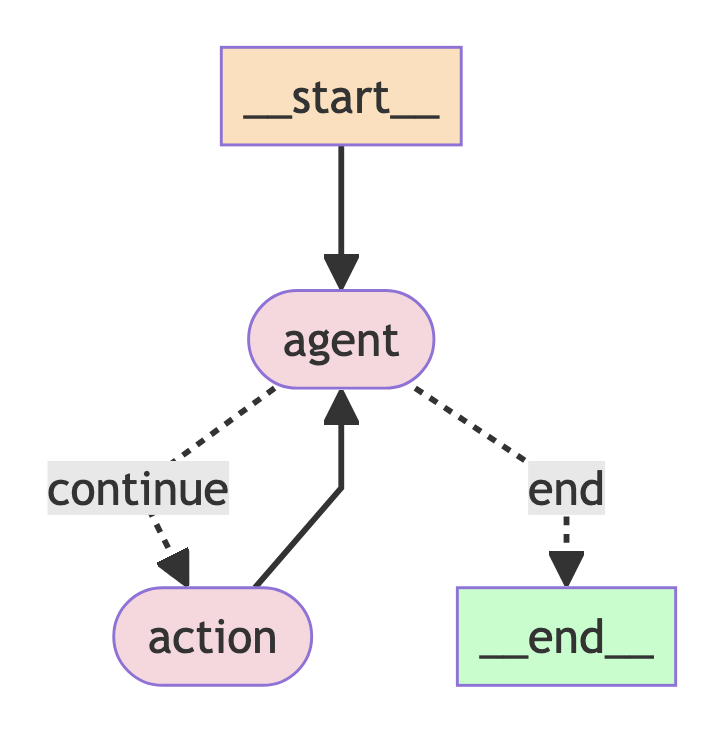

In [10]:
import nest_asyncio
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod

nest_asyncio.apply() # Required for Jupyter Notebook to run async functions

display_image(app.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    wrap_label_n_words=9,
    output_file_path=None,
    draw_method=MermaidDrawMethod.PYPPETEER,
    background_color="white",
    padding=10
))

### Using Mermaid.Ink


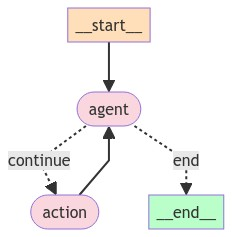

In [11]:
display_image(app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
))

## Excluding condition nodes
By default, condition nods like 'should_continue' will be added. In case you have a big graph and want to exclude these or simplicity, you can use add_condition_nodes parameter

In [12]:
display_image(app.get_graph(add_condition_nodes=False).draw_mermaid_png(
    draw_method=MermaidDrawMethod.PYPPETEER,
))


TypeError: CompiledGraph.get_graph() got an unexpected keyword argument 'add_condition_nodes'